In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.interpolate import UnivariateSpline

import lib

from lib import (
    FinnDir,
    load_exp_data,
    load_exp_conf,
    compute_core2B_profile,
    finn_fit_retardation,
)

In [2]:
finn_out_path = Path("../data_out/finn/")

# Core 2

## Training

In [3]:
data_core2_df = load_exp_data(name="Core 2")
conf_core2 = load_exp_conf(name="Core 2")

data_core2b_df = load_exp_data(name="Core 2B")
conf_core2b = load_exp_conf(name="Core 2B")

In [4]:
finn_core2_dir = FinnDir(finn_out_path / "core2")
# is_ok_to_delete = input(f"Remove {finn_core2_dir.path} (y/n)? ")
# if is_ok_to_delete == "y":
# shutil.rmtree(finn_core2_dir.path.absolute())
# finn_core2_dir = FinnDir(finn_root / "core2")
np.save(finn_core2_dir.c_train_path, data_core2_df["c_diss"])
np.save(finn_core2_dir.t_train_path, data_core2_df["time"])
finn_fit_retardation(
    out_dir=finn_core2_dir.path,
    is_exp_data=True,
    n_epochs=21,
    **conf_core2,
)

## Analysis

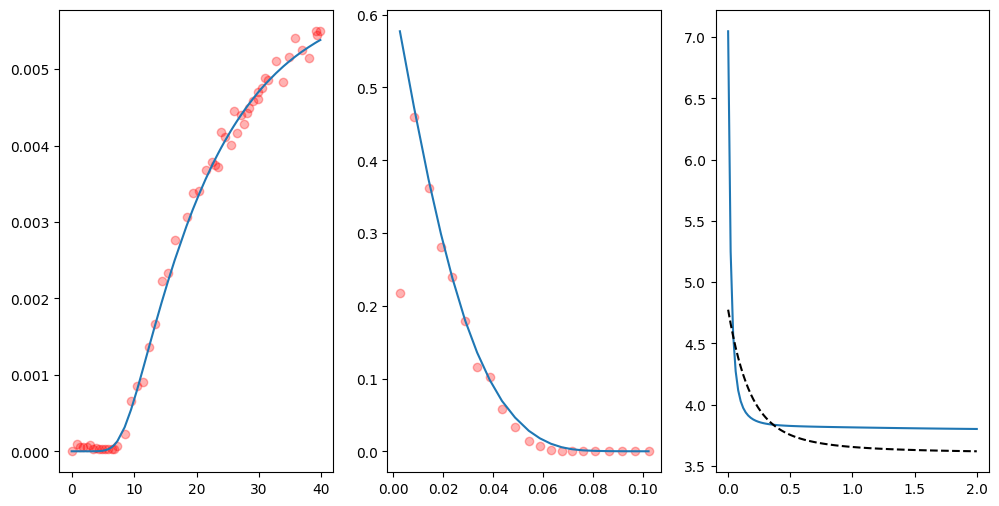

In [5]:
core2b_pred = compute_core2B_profile(finn_core2_dir)

u = np.load(finn_core2_dir.u_ret_path)

n_epochs = finn_core2_dir.n_epochs
fig, axs = plt.subplots(ncols=3, figsize=(12, 6))

axs[0].scatter(data_core2_df["time"], data_core2_df["c_diss"], color="red", alpha=0.3)
axs[0].plot(
    data_core2_df["time"],
    np.load(finn_core2_dir.get_data_pred_path(n_epochs - 1)),
    zorder=10,
)

axs[1].scatter(data_core2b_df["x"], data_core2b_df["c_tot"], color="red", alpha=0.3)
axs[1].plot(data_core2b_df["x"], core2b_pred, zorder=10)

axs[2].plot(*finn_core2_dir.best_ret_points)
axs[2].plot(
    u,
    np.load(
        "/Users/r/Documents/dev/tmp/finn_with_julia/python/diffusion_sorption/experimental_data/learned_retardation.npy"
    ),
    "k--",
)
plt.show()

# FINN Results from P3INN PIs

In [6]:
finn_root = finn_out_path / "p3inn_core2_new_multiprocessing"
finn_dirs = list(map(FinnDir, finn_root.iterdir()))

Skipping FinnDir(path=PosixPath('../data_out/finn/p3inn_core2_new_multiprocessing/down_0.95'))
[Errno 2] No such file or directory: '../data_out/finn/p3inn_core2_new_multiprocessing/up_0.95/finn_loss.txt.npy'


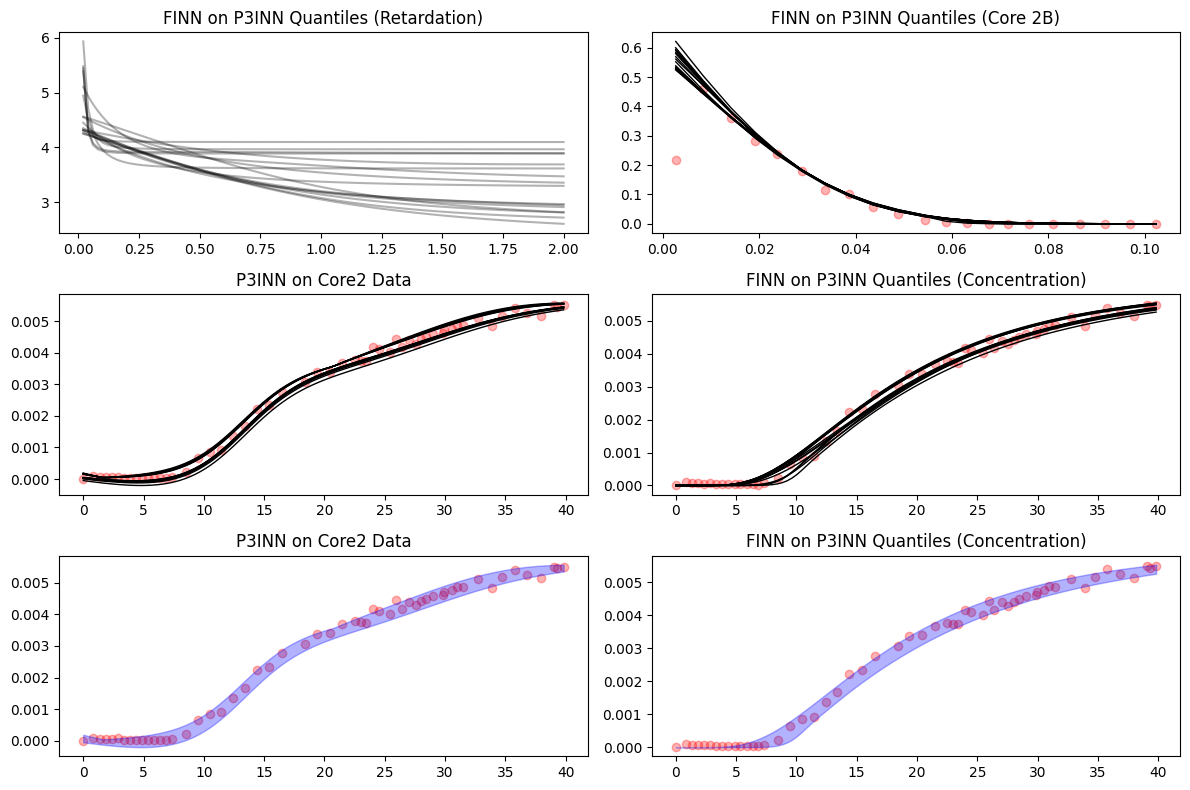

In [7]:
data_core2_df = load_exp_data("Core 2")
data_core2b_df = load_exp_data("Core 2B")

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 8))

data_kwargs = {"color": "red", "label": "Core2 Data", "alpha": 0.3, "edgecolor": None}
t_data = data_core2_df["time"]
axs[0, 1].scatter(data_core2b_df["x"], data_core2b_df["c_tot"], **data_kwargs)
axs[1, 0].scatter(data_core2_df["time"], data_core2_df["c_diss"], **data_kwargs)
axs[1, 1].scatter(data_core2_df["time"], data_core2_df["c_diss"], **data_kwargs)

all_core2_PIs_p3inn = []
all_core2_preds_finn = []
all_core2b_preds_finn = []

for finn_dir in finn_dirs:
    try:
        u_ret = np.load(finn_dir.u_ret_path)
        loss = np.load(finn_dir.loss_path)
        best_epoch = finn_dir.best_epoch
        ret = np.load(finn_dir.get_pred_ret_path(best_epoch))
        pred_data = np.load(finn_dir.get_data_pred_path(best_epoch))
        data = np.load(finn_dir.c_train_path)
    except FileNotFoundError as e:
        print(e)
        continue

    pred_kwargs = {"color": "black", "zorder": 1, "alpha": 1.0, "lw": 1.0}
    if np.any(ret < 1) or np.any(ret > 100):
        print("Skipping", finn_dir)
        pred_kwargs["color"] = "red"
        pred_kwargs["zorder"] = 10
        pred_kwargs["lw"] = 3
        continue

    core2b_c = compute_core2B_profile(finn_dir)

    all_core2_PIs_p3inn.append(data)
    all_core2_preds_finn.append(pred_data)
    all_core2b_preds_finn.append(core2b_c)

    t_eval = np.linspace(t_data.min(), t_data.max(), len(data))

    axs[0, 0].set_title("FINN on P3INN Quantiles (Retardation)")
    axs[0, 0].plot(u_ret[1:], ret[1:], "k-", alpha=0.3)

    axs[0, 1].set_title("FINN on P3INN Quantiles (Core 2B)")
    axs[0, 1].plot(data_core2b_df["x"], core2b_c, "-", **pred_kwargs)

    axs[1, 0].set_title("P3INN on Core2 Data")
    axs[1, 0].plot(t_eval, data, "-", **pred_kwargs)

    axs[1, 1].set_title("FINN on P3INN Quantiles (Concentration)")
    axs[1, 1].plot(t_eval, pred_data, "-", **pred_kwargs)

all_core2_PIs_p3inn = np.array(all_core2_PIs_p3inn)
all_core2_preds_finn = np.array(all_core2_preds_finn)
all_core2b_preds_finn = np.array(all_core2b_preds_finn)

bound_upper_p3inn = np.max(all_core2_PIs_p3inn, axis=0)
bound_lower_p3inn = np.min(all_core2_PIs_p3inn, axis=0)
bound_upper_finn = np.max(all_core2_preds_finn, axis=0)
bound_lower_finn = np.min(all_core2_preds_finn, axis=0)

pi_kwargs = dict(color="blue", alpha=0.3, zorder=10)
axs[2, 0].set_title("P3INN on Core2 Data")
axs[2, 0].fill_between(t_eval, bound_lower_p3inn, bound_upper_p3inn, **pi_kwargs)
axs[2, 0].scatter(data_core2_df["time"], data_core2_df["c_diss"], **data_kwargs)

axs[2, 1].set_title("FINN on P3INN Quantiles (Concentration)")
axs[2, 1].fill_between(t_eval, bound_lower_finn, bound_upper_finn, **pi_kwargs)
axs[2, 1].scatter(data_core2_df["time"], data_core2_df["c_diss"], **data_kwargs)

plt.tight_layout()
plt.show()

## Log-Likelihood

In [8]:
GIVEN_QUANTILE = 0.95

In [9]:
from dataclasses import dataclass


@dataclass
class LikelihoodResult:
    likelihood: np.ndarray
    sigmas: np.ndarray
    mean_gauss: np.ndarray
    bound_gauss_lower: np.ndarray
    bound_gauss_upper: np.ndarray

    def median_likelihood(self):
        return np.median(self.likelihood)

    def mean_likelihood(self, skip: int):
        return np.mean(self.likelihood[skip:])


def compute_loglikelihood_core2_normal(mean, upper, lower):
    # FIXME: Assumes 95% quantile is given
    # FINN paper has 95% PI -> 2.5% vals are below and 2.5% vals above
    c = -stats.norm.ppf((1 - GIVEN_QUANTILE) / 2)
    sigmas = (upper - lower) / (2 * c)
    sigmas[sigmas < 1e-14] = 1e-14
    gauss_upper = mean + c * sigmas
    gauss_lower = mean - c * sigmas

    # interpolation needed because of data_core2_df["c_diss"]
    mean_intp = np.interp(t_data, t_eval, mean)
    sigmas_intp = np.interp(t_data, t_eval, sigmas)
    log_likeli = stats.norm.logpdf(
        data_core2_df["c_diss"], loc=mean_intp, scale=sigmas_intp
    )

    return LikelihoodResult(log_likeli, sigmas, mean, gauss_lower, gauss_upper)


def _fit_skewnorm(mean, upper, lower):
    from scipy.optimize import minimize

    # Step 1: Estimate scale from 95% CI
    z_2_5 = stats.norm.ppf((1 - GIVEN_QUANTILE) / 2)
    z_97_5 = -stats.norm.ppf((1 - GIVEN_QUANTILE) / 2)
    assert z_97_5 > 0
    scale = (upper - lower) / (z_97_5 - z_2_5)

    # Step 2: Function to minimize (to estimate skewness)
    def skewnorm_mse(a):
        # Use loc=mean and scale from CI
        dist = stats.skewnorm(a, loc=mean, scale=scale)
        # Compare the percentiles with given bounds
        ci_lower, ci_upper = dist.ppf([0.025, 0.975])
        # Compute the mean squared error
        return (ci_lower - lower) ** 2 + (ci_upper - upper) ** 2

    # Step 3: Estimate skewness (shape parameter 'a')
    result = minimize(skewnorm_mse, x0=0)
    a = result.x[0]

    # The fitted skew-normal distribution has parameters:
    skewnorm_params = {"a": a, "loc": mean, "scale": scale}
    return skewnorm_params


def compute_loglikelihood_core2_skewed(mean, upper, lower):
    params = [_fit_skewnorm(m, u, l) for m, u, l in zip(mean, upper, lower)]
    a = np.array([params[i]["a"] for i in range(len(params))])
    loc = np.array([params[i]["loc"] for i in range(len(params))])
    scale = np.array([params[i]["scale"] for i in range(len(params))])

    # FIXME: Assumes 95% quantile is given
    # FINN paper has 95% PI -> 2.5% vals are below and 2.5% vals above
    ci_lower = stats.skewnorm.ppf(0.025, a=a, loc=loc, scale=scale)
    ci_upper = stats.skewnorm.ppf(0.975, a=a, loc=loc, scale=scale)

    # interpolation needed because of data_core2_df["c_diss"]
    ap = np.interp(t_data, t_eval, a)
    locp = np.interp(t_data, t_eval, loc)
    scalep = np.interp(t_data, t_eval, scale)
    log_likeli = stats.skewnorm.logpdf(
        data_core2_df["c_diss"], a=ap, loc=locp, scale=scalep
    )

    return LikelihoodResult(log_likeli, scale, mean, ci_lower, ci_upper)


compute_loglikelihood_core2 = compute_loglikelihood_core2_normal  # _skewed

MCMC: 7.583481477429193 7.3794634225714395
FINN: 7.5432251565153 7.4655871192316505


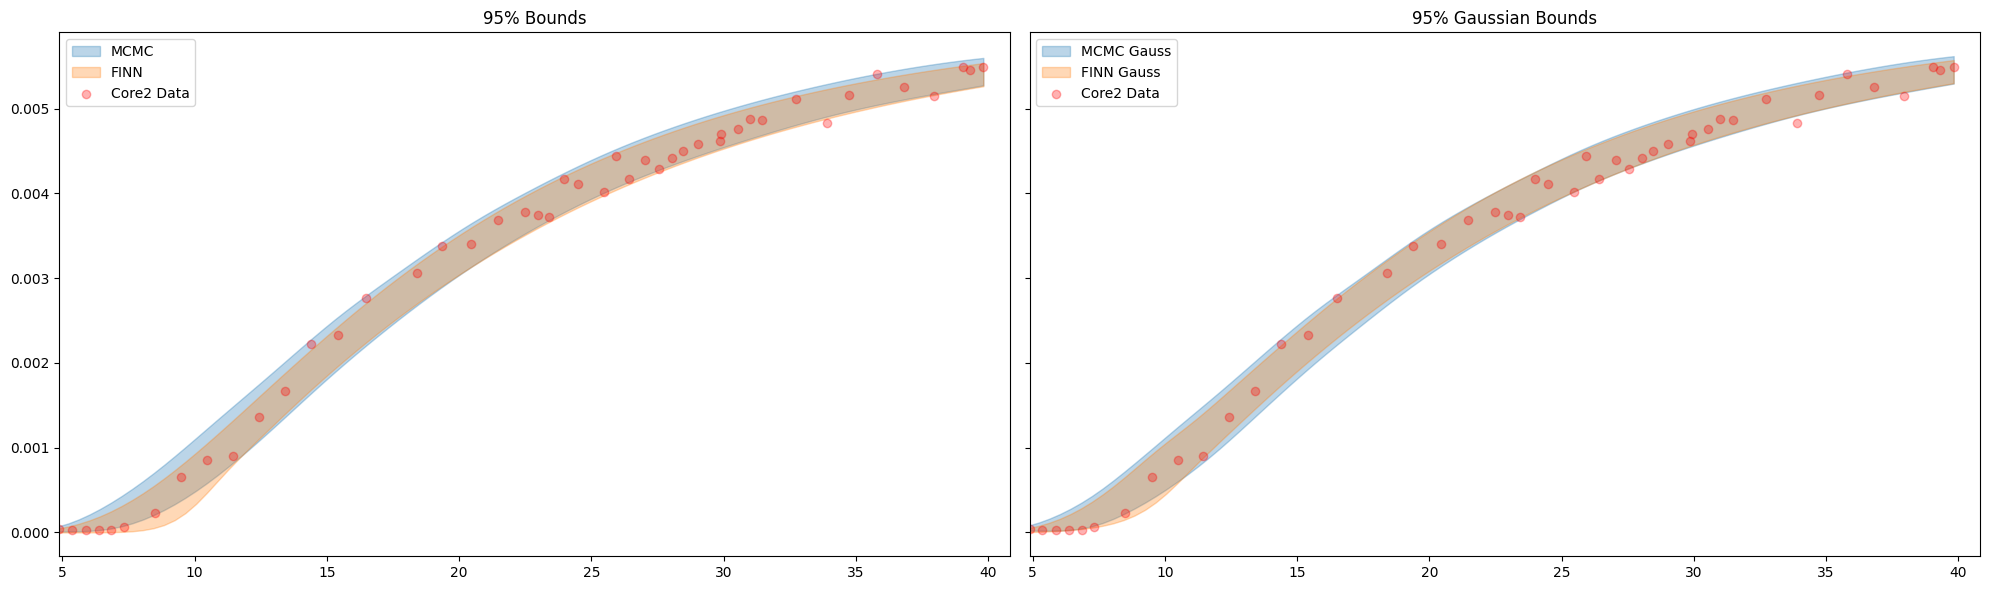

In [10]:
# MCMC Paper ----------------------------------------
mean_core2_df = (
    pd.read_csv("../data/digitized/mean_core2.csv")
    .sort_values("x")
    .reset_index(drop=True)
)
mean_core2_df["y"] /= 1000
upper_mcmc_PI_core2_df = (
    pd.read_csv("../data/digitized/upper_mcmc_PI_core2.csv")
    .sort_values("x")
    .reset_index(drop=True)
)
upper_mcmc_PI_core2_df["y"] /= 1000
lower_mcmc_PI_core2_df = (
    pd.read_csv("../data/digitized/lower_mcmc_PI_core2.csv")
    .sort_values("x")
    .reset_index(drop=True)
)
lower_mcmc_PI_core2_df["y"] /= 1000


mean_core2_paper = UnivariateSpline(mean_core2_df["x"], mean_core2_df["y"], s=0.0)(
    t_eval
)
upper_mcmc_PI_core2 = UnivariateSpline(
    upper_mcmc_PI_core2_df["x"], upper_mcmc_PI_core2_df["y"], s=0.0
)(t_eval)
lower_mcmc_PI_core2 = UnivariateSpline(
    lower_mcmc_PI_core2_df["x"], lower_mcmc_PI_core2_df["y"], s=0.0
)(t_eval)

loglikeli_result_mcmc = compute_loglikelihood_core2(
    mean_core2_paper, upper_mcmc_PI_core2, lower_mcmc_PI_core2
)

# FINN ----------------------------------------
mean_core2_preds_finn = np.mean(all_core2_preds_finn, axis=0)
loglikeli_result_finn = compute_loglikelihood_core2(
    mean_core2_preds_finn, bound_upper_finn, bound_lower_finn
)

fig, axs = plt.subplots(ncols=2, figsize=(20, 6), sharey=True)
# check that spline interpolation works
# plt.plot(lower_mcmc_PI_core2_df["x"], lower_mcmc_PI_core2_df["y"], "b-o")
# plt.plot(upper_mcmc_PI_core2_df["x"], upper_mcmc_PI_core2_df["y"], "b-o")
# plt.plot(mean_core2_df["x"], mean_core2_df["y"], "b-o")
# plt.plot(t_eval, mean_core2_paper)
# plt.plot(t_eval, upper_mcmc_PI_core2)
# plt.plot(t_eval, lower_mcmc_PI_core2)

SKIP = 9

axs[0].set_title("95% Bounds")
axs[0].fill_between(
    t_eval,
    lower_mcmc_PI_core2,
    upper_mcmc_PI_core2,
    alpha=0.3,
    color="C0",
    label="MCMC",
)
axs[0].fill_between(
    t_eval, bound_lower_finn, bound_upper_finn, alpha=0.3, color="C1", label="FINN"
)

axs[0].scatter(t_data, data_core2_df["c_diss"], **data_kwargs)
axs[0].set_xlim(t_data[SKIP:].min(), t_data.max() * 1.025)
axs[0].legend()


axs[1].set_title("95% Gaussian Bounds")
axs[1].fill_between(
    t_eval,
    loglikeli_result_mcmc.bound_gauss_lower,
    loglikeli_result_mcmc.bound_gauss_upper,
    alpha=0.3,
    color="C0",
    label="MCMC Gauss",
)
axs[1].fill_between(
    t_eval,
    loglikeli_result_finn.bound_gauss_lower,
    loglikeli_result_finn.bound_gauss_upper,
    alpha=0.3,
    color="C1",
    label="FINN Gauss",
)
axs[1].scatter(t_data, data_core2_df["c_diss"], **data_kwargs)
axs[1].set_xlim(t_data[SKIP:].min(), t_data.max() * 1.025)
axs[1].legend()


print(
    "MCMC:",
    loglikeli_result_mcmc.median_likelihood(),
    loglikeli_result_mcmc.mean_likelihood(skip=SKIP),
)
print(
    "FINN:",
    loglikeli_result_finn.median_likelihood(),
    loglikeli_result_finn.mean_likelihood(skip=SKIP),
)

plt.tight_layout()
plt.show()

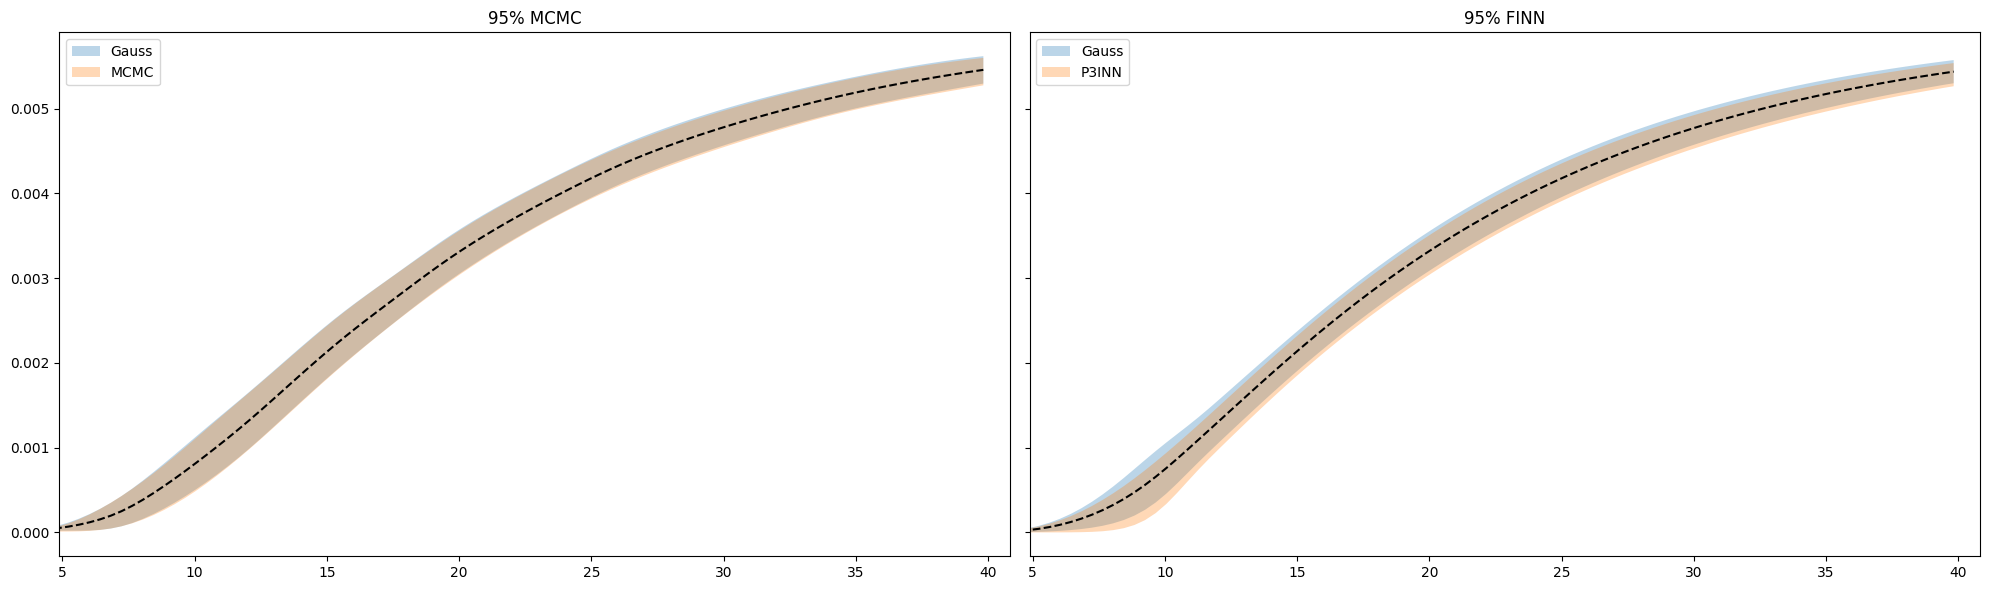

In [11]:
# MCMC Paper ----------------------------------------
mean_core2_df = (
    pd.read_csv("../data/digitized/mean_core2.csv")
    .sort_values("x")
    .reset_index(drop=True)
)
mean_core2_df["y"] /= 1000
upper_mcmc_PI_core2_df = (
    pd.read_csv("../data/digitized/upper_mcmc_PI_core2.csv")
    .sort_values("x")
    .reset_index(drop=True)
)
upper_mcmc_PI_core2_df["y"] /= 1000
lower_mcmc_PI_core2_df = (
    pd.read_csv("../data/digitized/lower_mcmc_PI_core2.csv")
    .sort_values("x")
    .reset_index(drop=True)
)
lower_mcmc_PI_core2_df["y"] /= 1000


mean_core2_paper = UnivariateSpline(mean_core2_df["x"], mean_core2_df["y"], s=0.0)(
    t_eval
)
upper_mcmc_PI_core2 = UnivariateSpline(
    upper_mcmc_PI_core2_df["x"], upper_mcmc_PI_core2_df["y"], s=0.0
)(t_eval)
lower_mcmc_PI_core2 = UnivariateSpline(
    lower_mcmc_PI_core2_df["x"], lower_mcmc_PI_core2_df["y"], s=0.0
)(t_eval)

loglikeli_result_mcmc = compute_loglikelihood_core2(
    mean_core2_paper, upper_mcmc_PI_core2, lower_mcmc_PI_core2
)

# FINN ----------------------------------------
mean_core2_preds_finn = np.mean(all_core2_preds_finn, axis=0)
loglikeli_result_finn = compute_loglikelihood_core2(
    mean_core2_preds_finn, bound_upper_finn, bound_lower_finn
)

fig, axs = plt.subplots(ncols=2, figsize=(20, 6), sharey=True)
# check that spline interpolation works
# plt.plot(lower_mcmc_PI_core2_df["x"], lower_mcmc_PI_core2_df["y"], "b-o")
# plt.plot(upper_mcmc_PI_core2_df["x"], upper_mcmc_PI_core2_df["y"], "b-o")
# plt.plot(mean_core2_df["x"], mean_core2_df["y"], "b-o")
# plt.plot(t_eval, mean_core2_paper)
# plt.plot(t_eval, upper_mcmc_PI_core2)
# plt.plot(t_eval, lower_mcmc_PI_core2)

SKIP = 9

axs[0].set_title("95% MCMC")
axs[0].plot(t_eval, loglikeli_result_mcmc.mean_gauss, "k--")
axs[0].fill_between(
    t_eval,
    loglikeli_result_mcmc.bound_gauss_lower,
    loglikeli_result_mcmc.bound_gauss_upper,
    alpha=0.3,
    label="Gauss",
)
axs[0].fill_between(
    t_eval, lower_mcmc_PI_core2, upper_mcmc_PI_core2, alpha=0.3, label="MCMC"
)
# axs[0].scatter(t_data, data_core2_df["c_diss"], **data_kwargs)
axs[0].set_xlim(t_data[SKIP:].min(), t_data.max() * 1.025)
axs[0].legend()


axs[1].set_title("95% FINN")
axs[1].plot(t_eval, loglikeli_result_finn.mean_gauss, "k--")
axs[1].fill_between(
    t_eval,
    loglikeli_result_finn.bound_gauss_lower,
    loglikeli_result_finn.bound_gauss_upper,
    alpha=0.3,
    label="Gauss",
)
axs[1].fill_between(
    t_eval, bound_lower_finn, bound_upper_finn, alpha=0.3, label="P3INN"
)
# axs[1].scatter(t_data, data_core2_df["c_diss"], **data_kwargs)
axs[1].set_xlim(t_data[SKIP:].min(), t_data.max() * 1.025)
axs[1].legend()

plt.tight_layout()
plt.show()

# PI3NN on "FINN on PI3NN"

In [12]:
p3inn_data_out_path = Path("../data_out/p3inn/")

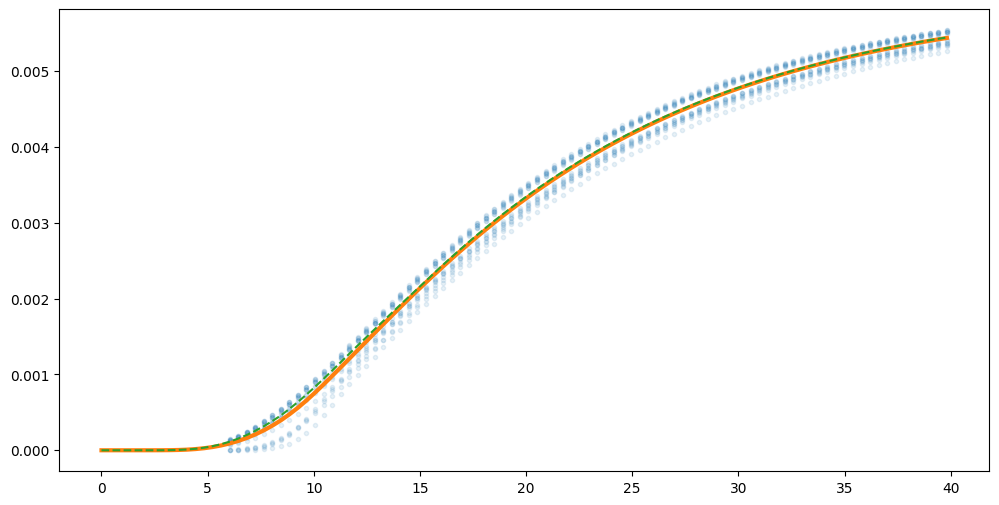

In [13]:
p3inn_btc_x_data = np.repeat(t_eval, all_core2_preds_finn.shape[0])
p3inn_btc_y_data = all_core2_preds_finn.T.flatten()
shuffle_indices = np.arange(p3inn_btc_y_data.shape[0])
np.random.shuffle(shuffle_indices)
p3inn_btc_x_data = p3inn_btc_x_data[shuffle_indices]
p3inn_btc_y_data = p3inn_btc_y_data[shuffle_indices]
mask = p3inn_btc_x_data > 6
p3inn_btc_x_data = p3inn_btc_x_data[mask]
p3inn_btc_y_data = p3inn_btc_y_data[mask]

plt.figure(figsize=(12, 6))
plt.plot(p3inn_btc_x_data, p3inn_btc_y_data, ".", alpha=0.1)
plt.plot(t_eval, np.mean(all_core2_preds_finn, axis=0), "-", lw=3)
plt.plot(t_eval, np.median(all_core2_preds_finn, axis=0), "--")
plt.show()

Training UP Network
Epoch      1, Train Loss: 2.93e+00, Validation Loss: 2.99e+00
Epoch   2000, Train Loss: 1.58e-02, Validation Loss: 1.20e-02
Epoch   4000, Train Loss: 1.63e-02, Validation Loss: 1.11e-02
Epoch   6000, Train Loss: 1.54e-02, Validation Loss: 1.14e-02
Epoch   8000, Train Loss: 1.55e-02, Validation Loss: 1.10e-02
Epoch  10000, Train Loss: 1.48e-02, Validation Loss: 1.16e-02
Epoch  12000, Train Loss: 1.46e-02, Validation Loss: 1.16e-02
Epoch  14000, Train Loss: 1.48e-02, Validation Loss: 1.16e-02
Epoch  16000, Train Loss: 1.52e-02, Validation Loss: 1.04e-02
Epoch  18000, Train Loss: 1.56e-02, Validation Loss: 1.04e-02
Epoch  20000, Train Loss: 1.53e-02, Validation Loss: 1.03e-02
Training DOWN Network
Epoch      1, Train Loss: 2.91e+00, Validation Loss: 2.99e+00
Epoch   2000, Train Loss: 3.31e-02, Validation Loss: 3.57e-02
Epoch   4000, Train Loss: 3.30e-02, Validation Loss: 3.57e-02
Epoch   6000, Train Loss: 3.28e-02, Validation Loss: 3.57e-02
Epoch   8000, Train Loss: 3.

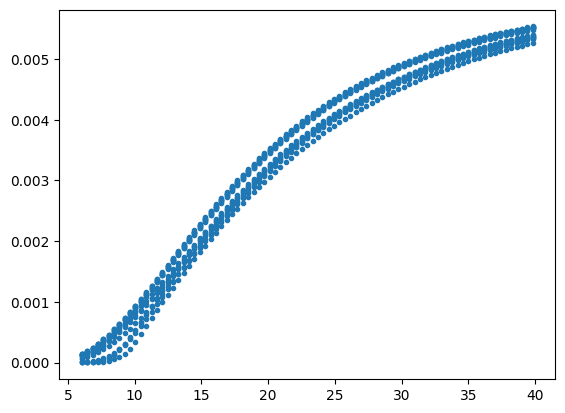

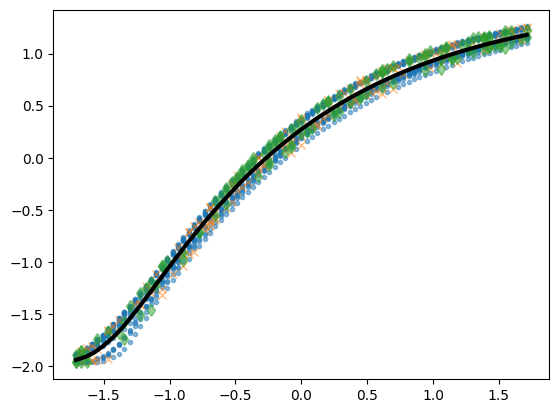

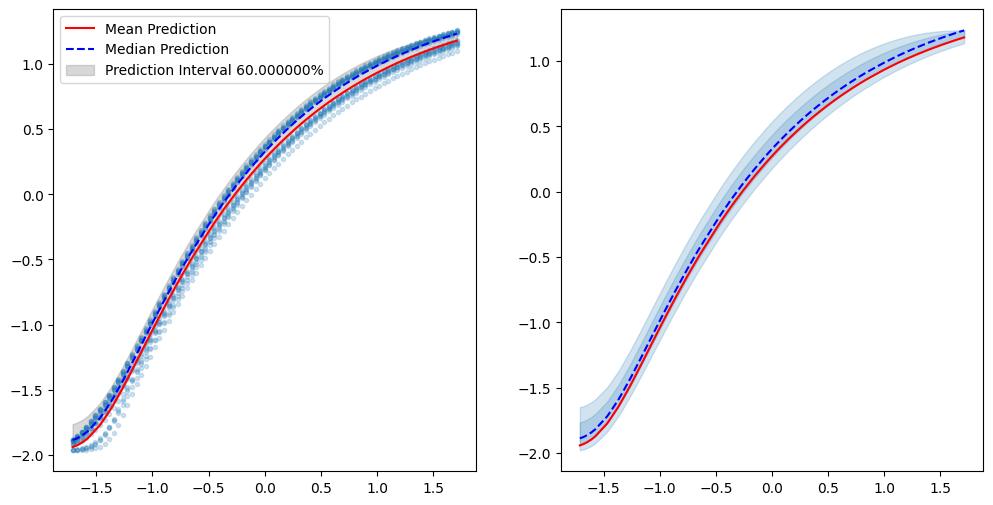

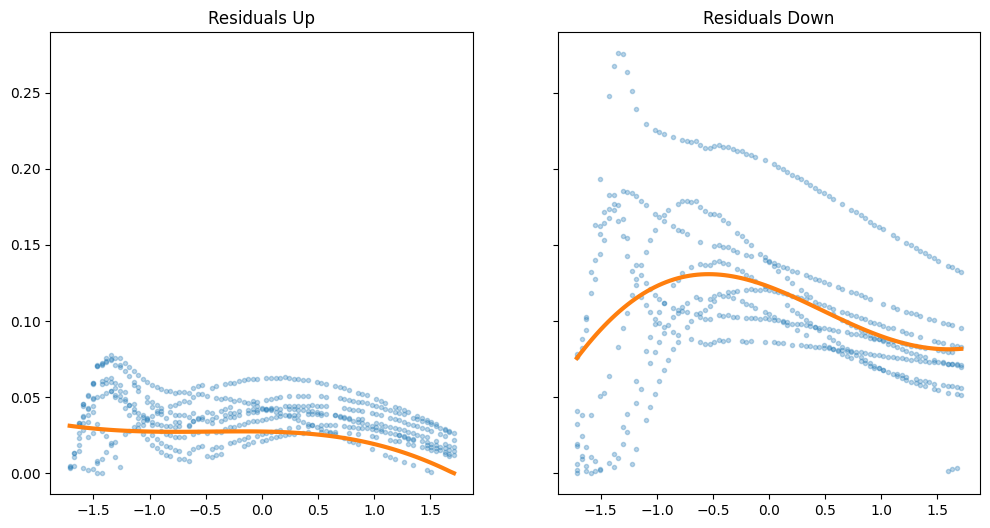

In [14]:
import lib
import shutil
import importlib

importlib.reload(lib)

p3inn_finnpinn_dir = lib.P3innDir(p3inn_data_out_path / "finn_btcs/")
shutil.rmtree(p3inn_finnpinn_dir.path)
p3inn_finnpinn_dir = lib.P3innDir(p3inn_data_out_path / "finn_btcs/")

np.save(p3inn_finnpinn_dir.x_data_path, p3inn_btc_x_data[..., None])
np.save(p3inn_finnpinn_dir.y_data_path, p3inn_btc_y_data[..., None])

core2_dir = FinnDir(Path("../data_out/finn/core2"))
fp = np.load(core2_dir.get_data_pred_path(core2_dir.best_epoch))
xp = np.load(core2_dir.t_train_path)


def net_mean(x):
    y = np.interp(x, xp, fp).reshape(-1, 1)
    return y


# lib.pi3nn_compute_PI_and_mean(p3inn_finnpinn_dir.path, quantiles=[0.9, 0.95, 0.975, 0.05, 0.025], visualize=True, net_mean=net_mean)
lib.pi3nn_compute_PI_and_mean(
    p3inn_finnpinn_dir.path,
    # quantiles=[0.9, 0.95, 0.975, 0.05, 0.025],
    quantiles=[0.9, 0.6],
    visualize=True,
    net_mean_=net_mean,
    max_iter=20000,
)
plt.show()

680
680
0

Final delta 0


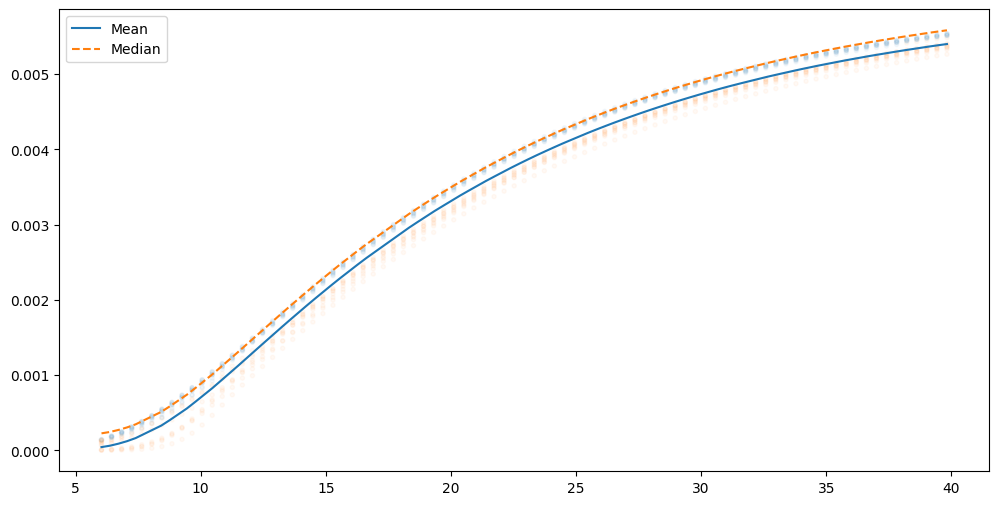

In [15]:
x_data = np.load((p3inn_finnpinn_dir.x_data_path)).ravel()
y_data = np.load((p3inn_finnpinn_dir.y_data_path)).ravel()
x_eval = np.load((p3inn_finnpinn_dir.x_eval_path)).ravel()
y_eval = np.load((p3inn_finnpinn_dir.pred_mean_path)).ravel()
y_eval_median = np.load((p3inn_finnpinn_dir.pred_median_path)).ravel()

import common

points = np.array([x_data, y_data]).T
delta = 0
# for _ in range(15):
#     delta += 1e-5
above_median = common.is_above_curve(x_eval, y_eval_median + delta, points)
below_median = common.is_below_curve(x_eval, y_eval_median + delta, points)
print(np.count_nonzero(above_median))
print(np.count_nonzero(below_median))
print(delta)
print()

print(f"Final delta {delta}")

color = np.where(above_median, "C0", "C1")
plt.figure(figsize=(12, 6))
plt.scatter(*points.T, alpha=0.04, c=color, marker=".")
plt.plot(x_eval, y_eval, "-", label="Mean")
plt.plot(x_eval, y_eval_median + 9e-05, "--", label="Median")
plt.legend()
plt.show()

# Appendix

## All FINN predictions for PI3NN PIs separately

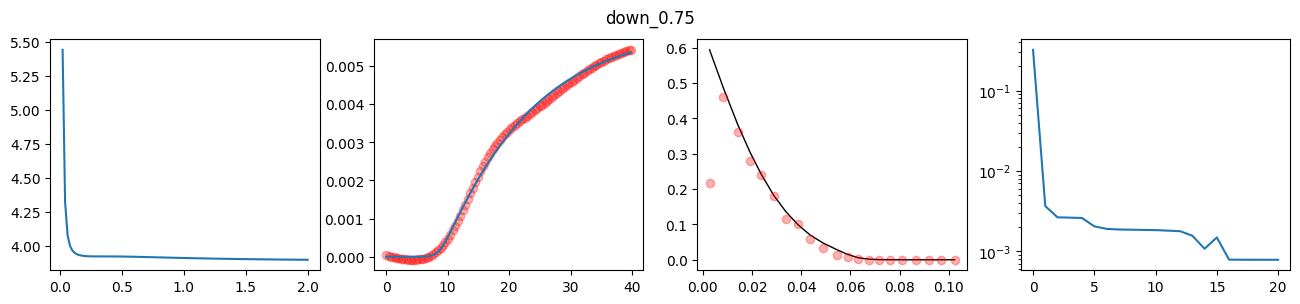

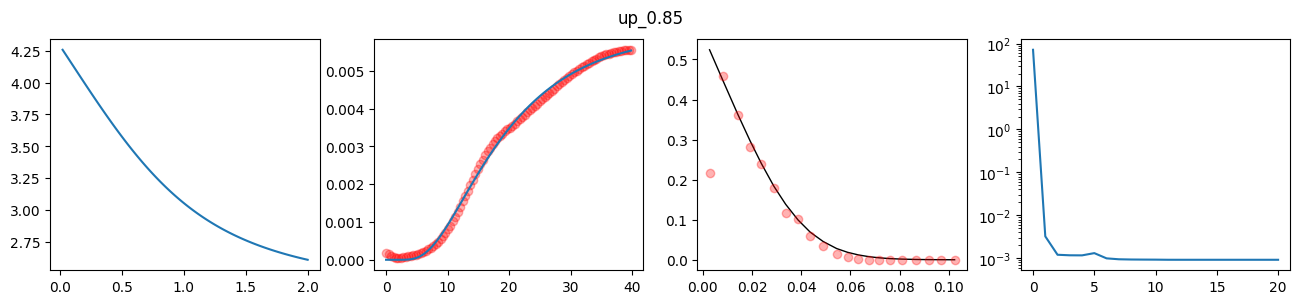

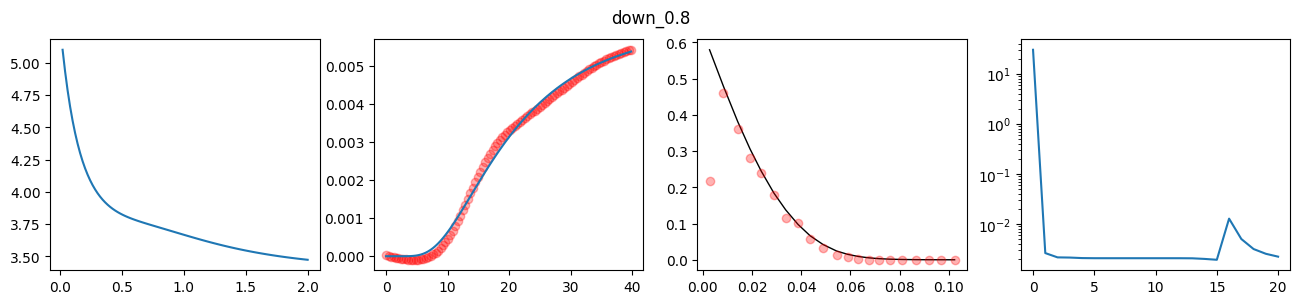

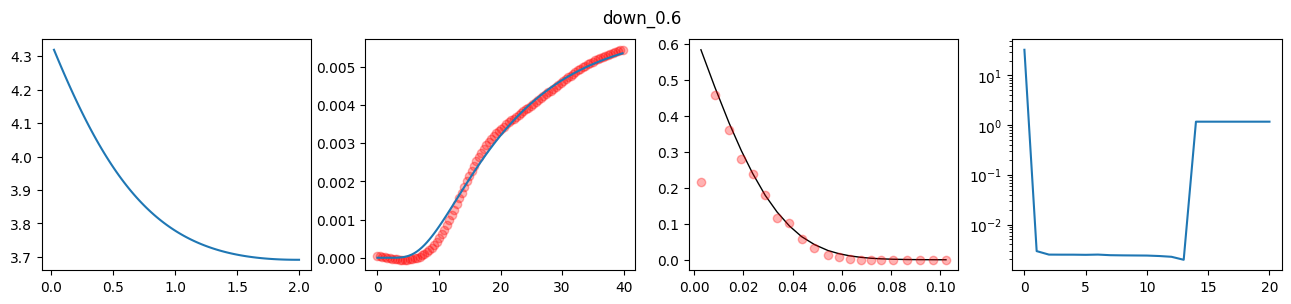

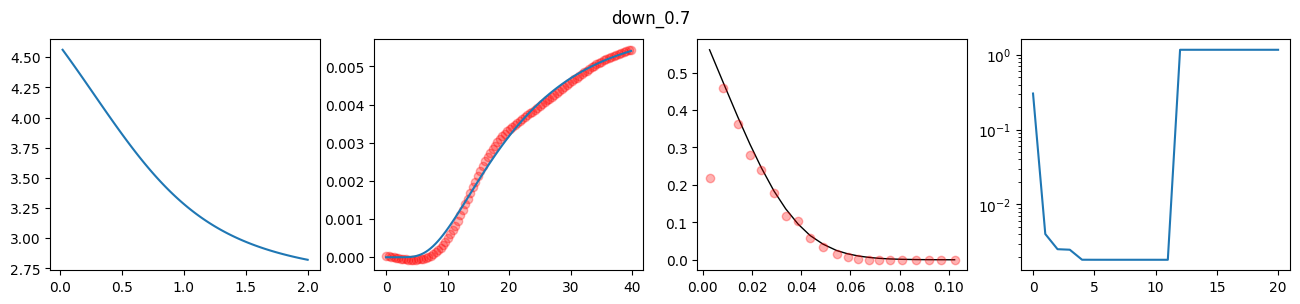

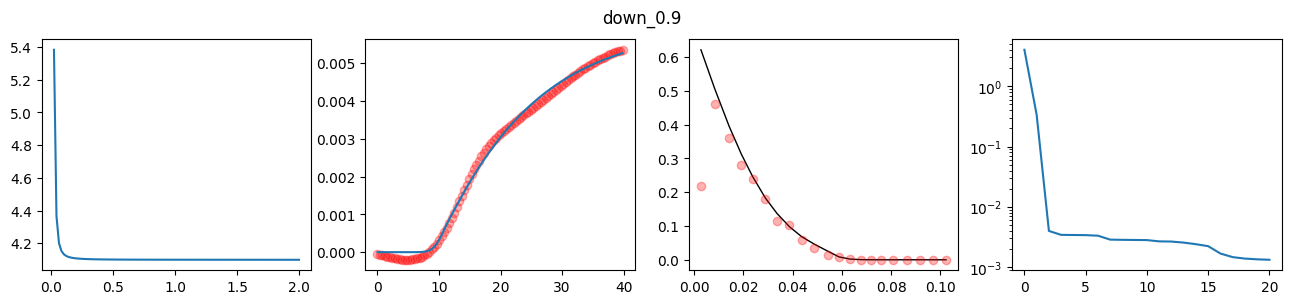

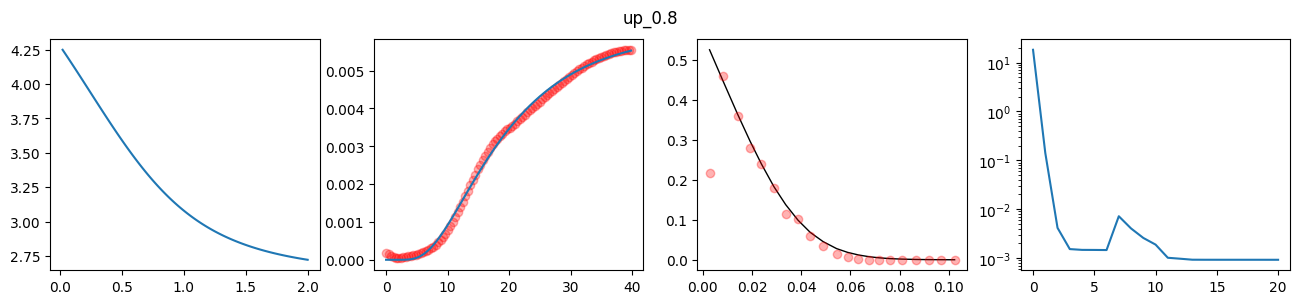

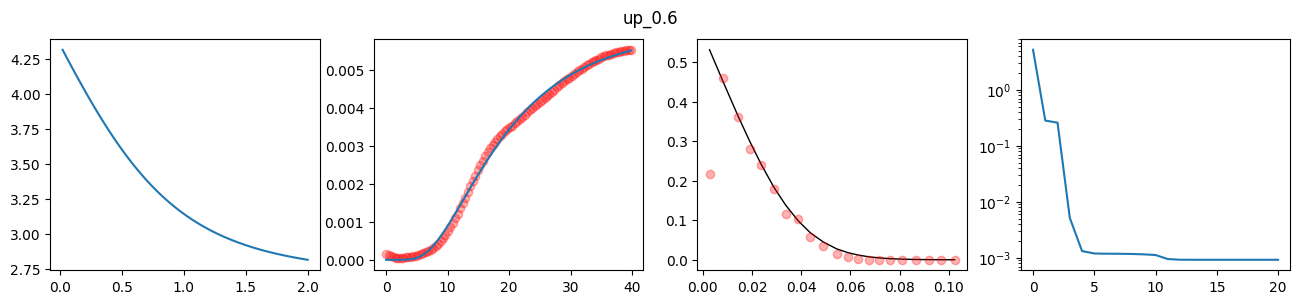

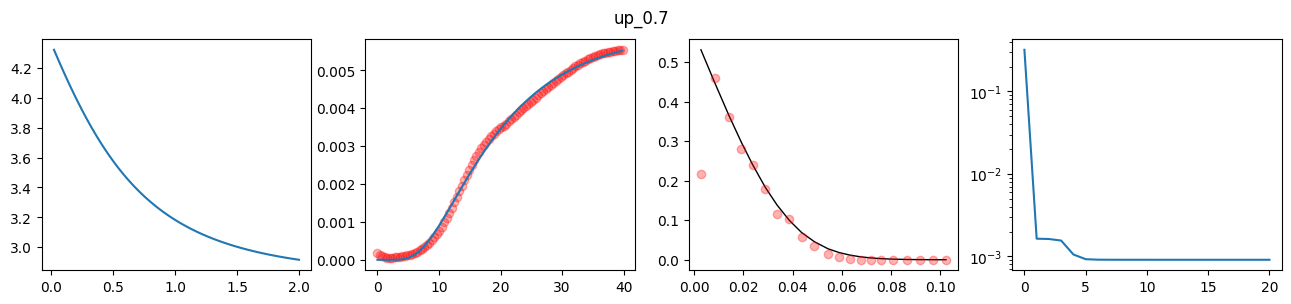

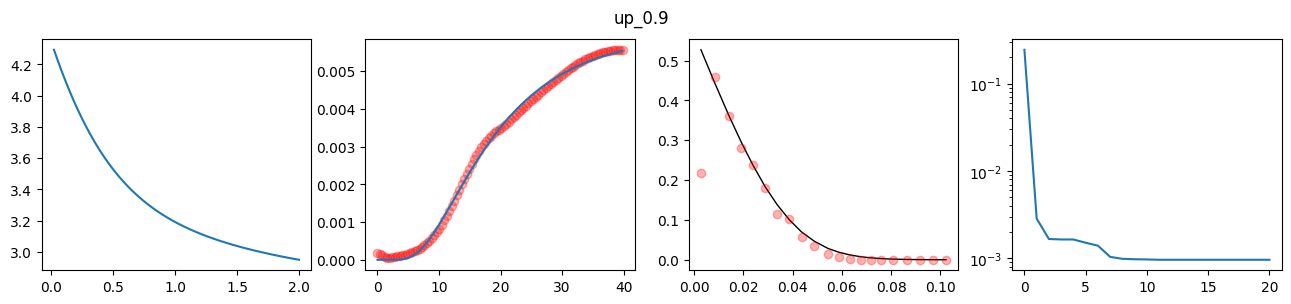

Skipping due to dt = 0 FinnDir(path=PosixPath('../data_out/finn/p3inn_core2_new_multiprocessing/down_0.95'))


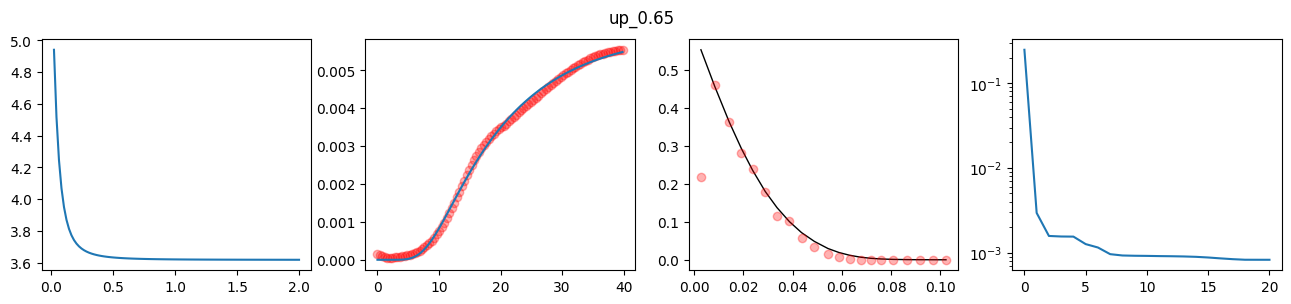

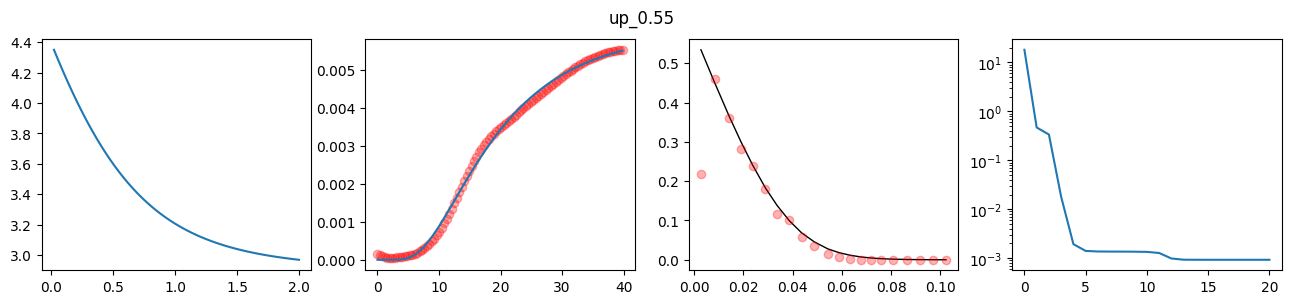

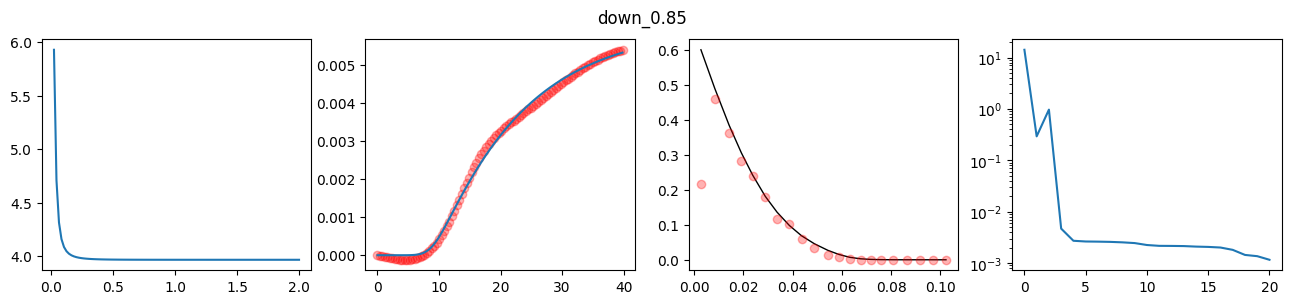

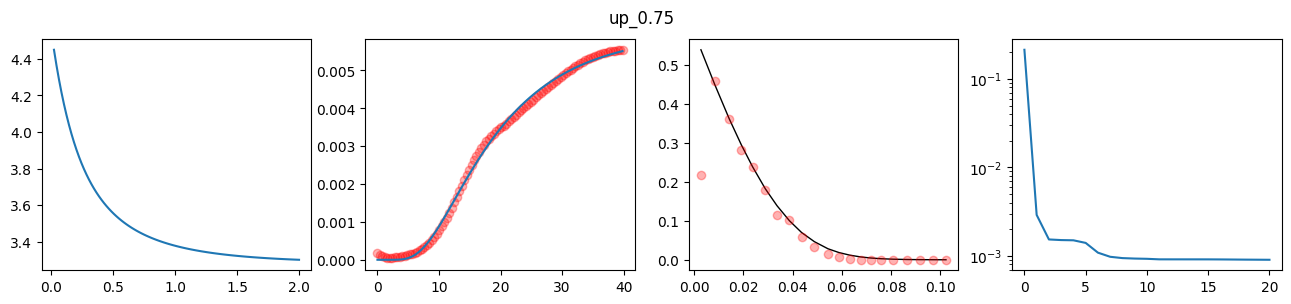

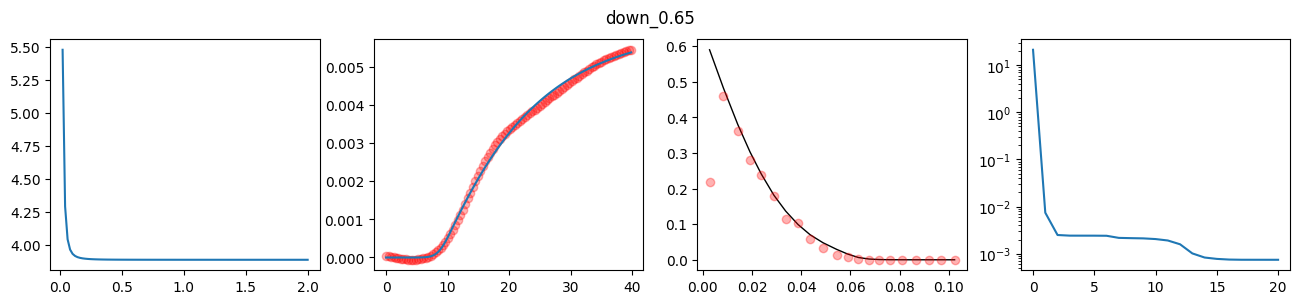

[Errno 2] No such file or directory: '../data_out/finn/p3inn_core2_new_multiprocessing/up_0.95/finn_loss.txt.npy'


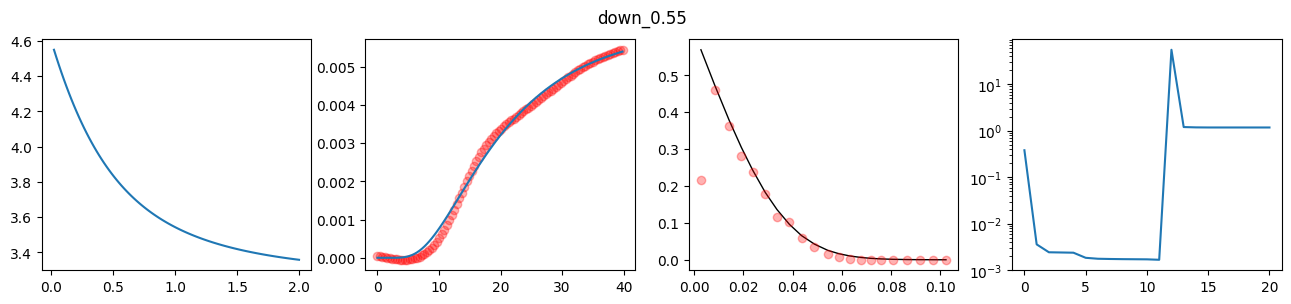

In [16]:
for finn_dir in finn_dirs:
    try:
        u_ret = np.load(finn_dir.u_ret_path)
        loss = np.load(finn_dir.loss_path)
        best_epoch = finn_dir.best_epoch
        ret = np.load(finn_dir.get_pred_ret_path(best_epoch))
        pred_data = np.load(finn_dir.get_data_pred_path(best_epoch))
        data = np.load(finn_dir.c_train_path)
    except FileNotFoundError as e:
        print(e)
        continue

    try:
        core2b_c = compute_core2B_profile(finn_dir)
    except AssertionError:
        print("Skipping due to dt = 0", finn_dir)
        continue

    fig, axs = plt.subplots(ncols=4, figsize=(16, 3))
    fig.suptitle(f"{finn_dir.path.name}")

    axs[0].plot(u_ret[1:], ret[1:])

    axs[1].scatter(t_eval, data, **data_kwargs)
    axs[1].plot(t_eval, pred_data, "-")

    axs[2].plot(data_core2b_df["x"], core2b_c, "-", **pred_kwargs)
    axs[2].scatter(data_core2b_df["x"], data_core2b_df["c_tot"], **data_kwargs)

    axs[3].semilogy(loss, "-")

    plt.show()